In [1]:
import netCDF4
import shapely.geometry
import numpy as np
import functools

from shapely.strtree import STRtree

%load_ext line_profiler

In [2]:
path = '/Users/baart_f/data/odv/public/profiles/data_from_SDN_2015-09_TS_MedSea_QC_done_v2.nc'

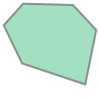

In [3]:
geom = shapely.geometry.asShape({ 
    "type": "Polygon", 
    "coordinates": [ [ [ 4.044615908002364, 41.968590393183135 ], [ 4.584833470736417, 42.571950268444546 ], [ 5.980980158841305, 42.536871205929344 ], [ 6.633450721623992, 41.835289955625377 ], [ 6.324754971490249, 40.312858642465777 ], [ 4.556770220724259, 40.902186892721105 ], [ 4.556770220724259, 40.902186892721105 ], [ 4.044615908002364, 41.968590393183135 ] ] ] 
})
geom

In [4]:
@functools.lru_cache()
def tree_from_path(path):
    # get lat, lon from the dataset
    with netCDF4.Dataset(path) as ds:
        lon = ds.variables['longitude'][:]
        lat = ds.variables['latitude'][:]
    
    # create spatial points so that we can query by geometry
    points = [
        shapely.geometry.Point(lon_i, lat_i) 
        for lon_i, lat_i 
        in zip(lon, lat)
    ]

    index_by_id = dict((id(pt), i) for i, pt in enumerate(points))
    tree = STRtree(points)
    return tree, index_by_id


In [17]:
def query_tree(tree, index_by_id, geom):
    """lookup the indices by geometry"""
    shapes = tree.query(geom)
    idx = [
        index_by_id[id(pt)] for pt in shapes
    ]
    # improves performance by a factor of 3
    # sort to make it faster
    idx = list(sorted(idx))
    return idx


In [21]:
def query_path_by_geometry(path, geom, max_n=300):
    tree, index_by_id = tree_from_path(path)
    idx = query_tree(tree, index_by_id, geom)

    
    if len(idx) > max_n:
        # if we have more than 300 stationss this function takes over 5s
        # let's just return a random sample of 1000 points
        sample = np.random.choice(idx, max_n, replace=False)
        # sort and rename to idx
        idx = list(sorted(sample))
    
    # now that we have <=max_n ids, get the data for each of them. 
    with netCDF4.Dataset(path) as ds:

        # create a list with the var that contain the temperature, salinity and depth values
        var_names = [
            name
            for name, var
            in ds.variables.items()
            if (name.startswith('var') and not '_' in name)
        ]
        var_names

        idx_variables = {}
        for var_name in var_names:
            var = ds.variables[var_name]

            try:
                idx_variables[var.long_name] = var[idx]
            except AttributeError:
                print ("failed to index {} with index {}".format(var,  idx))
    return idx_variables


In [22]:
# first call will cache the tree for this path
tree, index_by_id = tree_from_path(path)


In [23]:
%%timeit
# now we can query a 300 point sample from a 10000 station covering geometry in 2s
idx_variables = query_path_by_geometry(path, geom)

sampling 300 idx from 10576
sampling 300 idx from 10576
sampling 300 idx from 10576
sampling 300 idx from 10576
sampling 300 idx from 10576
sampling 300 idx from 10576
sampling 300 idx from 10576
sampling 300 idx from 10576
2.89 s ± 60.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
